In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fb-recommendation/FB_Models.ipynb
/kaggle/input/fb-recommendation/FB_EDA.ipynb
/kaggle/input/fb-recommendation/train_woheader_sample.csv
/kaggle/input/fb-recommendation/FB_featurization.ipynb
/kaggle/input/fb-recommendation/train.csv
/kaggle/input/fb-recommendation/test.csv


In [14]:
os.getcwd()

'/kaggle/working'

In [15]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx #graph manipulation library
import pdb
import pickle

In [16]:

#reading graph
if not os.path.isfile('/kaggle/working/train_woheader.csv'): # if path contains this file - file without header
    traincsv = pd.read_csv('train.csv') # reading the default file, the raw data
    print(traincsv[traincsv.isna().any(1)])
    print(traincsv.info())
    print("Number of diplicate entries: ",sum(traincsv.duplicated()))
    traincsv.to_csv('/kaggle/working/train_woheader.csv',header=False,index=False) #creating a file without header
    print("saved the graph into file")
else:
    # creating the graph 'g' using networkx library, here each node is represented as integer
    g=nx.read_edgelist('/kaggle/working/train_woheader.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(g))

Name: 
Type: DiGraph
Number of nodes: 1862220
Number of edges: 9437519
Average in degree:   5.0679
Average out degree:   5.0679


Name: 
Type: DiGraph
Number of nodes: 66
Number of edges: 50
Average in degree:   0.7576
Average out degree:   0.7576


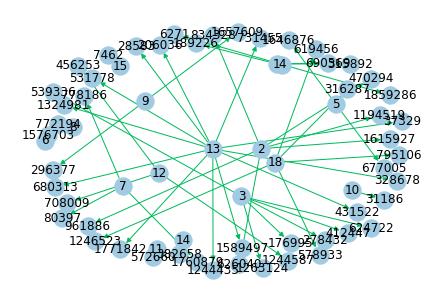

In [18]:

if not os.path.isfile('../input/fb-recommendation/train_woheader_sample.csv'):
    pd.read_csv('train.csv', nrows=50).to_csv('../input/fb-recommendation/train_woheader_sample.csv',header=False,index=False)
    
# creating a subgraph, which is basically a subset of vertices and edges
subgraph=nx.read_edgelist('../input/fb-recommendation/train_woheader_sample.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
# https://stackoverflow.com/questions/9402255/drawing-a-huge-graph-with-networkx-and-matplotlib

pos=nx.spring_layout(subgraph)
nx.draw(subgraph,pos,node_color='#A0CBE2',edge_color='#00bb5e',width=1,edge_cmap=plt.cm.Blues,with_labels=True)
plt.savefig("/kaggle/working/graph_sample.pdf")
print(nx.info(subgraph))

# 1. Exploratory Data Analysis

In [19]:
# Printing the of Unique persons 
print("The number of unique persons",len(g.nodes()))

The number of unique persons 1862220


# 1.1 No of followers for each person

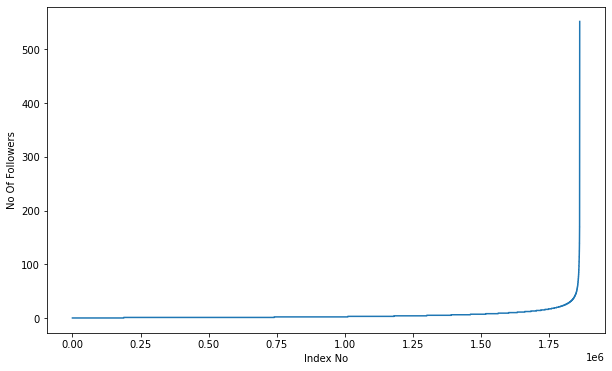

In [20]:
# Plotting the graph of followers, which is indegree
indegree_dist = list(dict(g.in_degree()).values()) # getting the list of all the indegrees of all vertices
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist) # plotting the simple line graph of indegree between number of users
plt.xlabel('Index No') # this shows the number at the factor of million (0.25 being 250000 records)
plt.ylabel('No Of Followers')
plt.show()

##### Observation : Most of the users have very less no of followers and a hand ful of users has very high no of followers

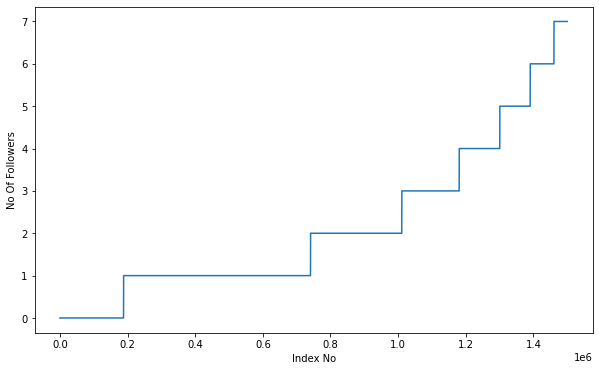

In [21]:
# simple zoom into the above mentioned graph where the number of users are restricted to 1.5M
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist[0:1500000])# restricting users to 1.5M
plt.xlabel('Index No')
plt.ylabel('No Of Followers')
plt.show()

##### observation : most of the users dosen't have much followers

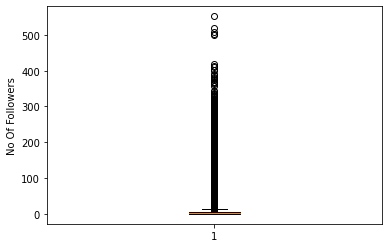

In [22]:
# Box-plot to check for total no of followers
plt.boxplot(indegree_dist)
plt.ylabel('No Of Followers')
plt.show()

In [23]:
### observing 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(indegree_dist,90+i))

90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 552.0


##### observation: the maximum no of followers for a user is 552

In [24]:
### 99.0-100th percentile with closer decimal points
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(indegree_dist,99+(i/100)))

99.1 percentile value is 42.0
99.2 percentile value is 44.0
99.3 percentile value is 47.0
99.4 percentile value is 50.0
99.5 percentile value is 55.0
99.6 percentile value is 61.0
99.7 percentile value is 70.0
99.8 percentile value is 84.0
99.9 percentile value is 112.0
100.0 percentile value is 552.0


##### observation : 99.9% of people have less than 112 followers

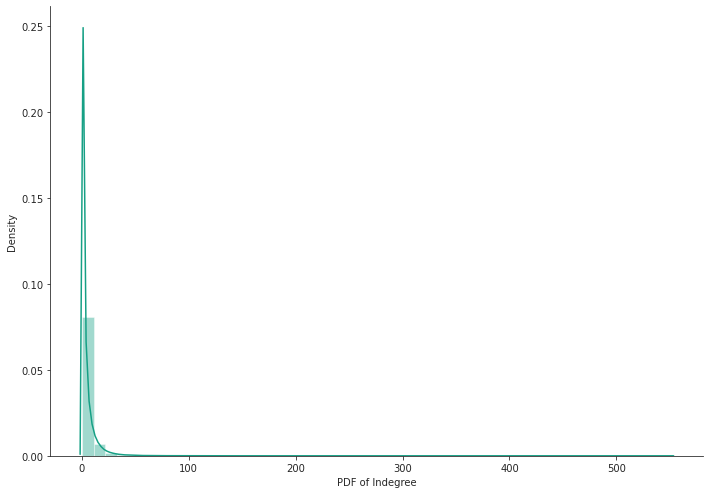

In [25]:
# Plotting PDF graph of indegree
%matplotlib inline
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.distplot(indegree_dist, color='#16A085')
plt.xlabel('PDF of Indegree')
sns.despine()
#plt.show()

##### Observation : the PDF for indegree is more concentrated towards less than 50 followers

# 1.2 No of people each person is following

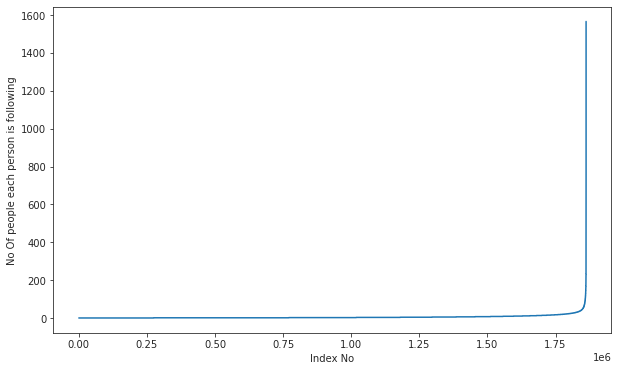

In [26]:
# Plotting the graph of outdegree for all users
outdegree_dist = list(dict(g.out_degree()).values())
outdegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist)
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following')
plt.show()

##### observation : more than 90% of people are following less than 1600 people

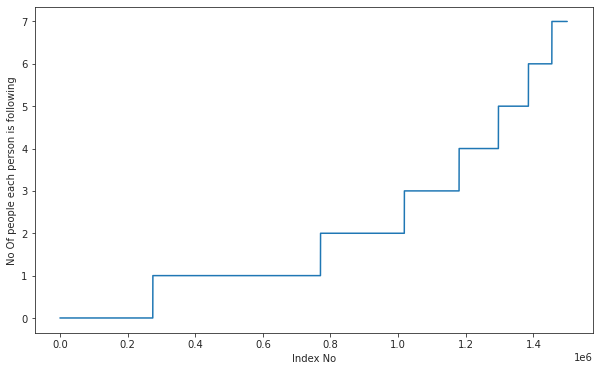

In [27]:
# zooming in into above plot and restricting users to 1.5M
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist[0:1500000])#restricting users to 1.5M
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following')
plt.show()

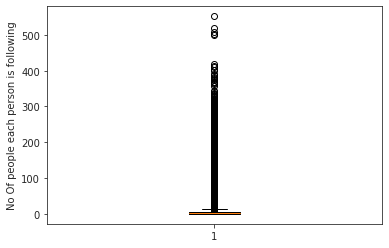

In [28]:
#BOXPLOT
plt.boxplot(indegree_dist)
plt.ylabel('No Of people each person is following')
plt.show()

##### it is observed that only bunch of people are following more than 500 people

In [29]:
### 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(outdegree_dist,90+i))

90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 1566.0


##### observation: more than 99% of people are following less than 40 people

In [30]:
### 99.0-100 percentile with decimal intervals
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(outdegree_dist,99+(i/100)))

99.1 percentile value is 42.0
99.2 percentile value is 45.0
99.3 percentile value is 48.0
99.4 percentile value is 52.0
99.5 percentile value is 56.0
99.6 percentile value is 63.0
99.7 percentile value is 73.0
99.8 percentile value is 90.0
99.9 percentile value is 123.0
100.0 percentile value is 1566.0


##### observation : more than 99.9% of people are following less than 123 followees

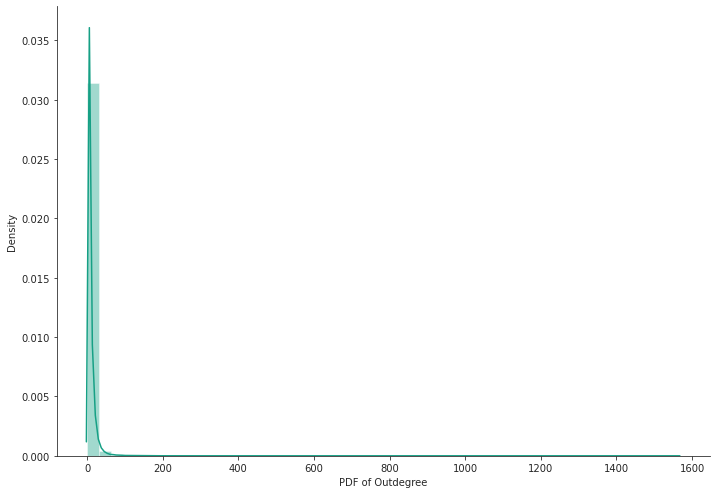

In [31]:
# PDF curve of ourdegree
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.distplot(outdegree_dist, color='#16A085')
plt.xlabel('PDF of Outdegree')
sns.despine()

##### Observation : the outdegree is most observed at some intervals between 0-50

In [32]:
print('No of persons those are not following anyone are' ,sum(np.array(outdegree_dist)==0),'and % is',
                                sum(np.array(outdegree_dist)==0)*100/len(outdegree_dist) )

No of persons those are not following anyone are 274512 and % is 14.741115442858524


In [33]:
print('No of persons having zero followers are' ,sum(np.array(indegree_dist)==0),'and % is',
                                sum(np.array(indegree_dist)==0)*100/len(indegree_dist) )

No of persons having zero followers are 188043 and % is 10.097786512871734


In [34]:
count=0
for i in g.nodes():
    if len(list(g.predecessors(i)))==0 : #A predecessor of n is a node m such that there exists a directed edge from m to n.
        if len(list(g.successors(i)))==0:#A successor of n is a node m such that there exists a directed edge from n to m.
            count+=1
print('No of persons those are not not following anyone and also not having any followers are',count)

No of persons those are not not following anyone and also not having any followers are 0


# 1.3 both followers + following

In [35]:
from collections import Counter
dict_in = dict(g.in_degree()) #in_degree is the number of edges pointing to the node.. 
dict_out = dict(g.out_degree()) #in_degree is the number of edges pointing to the node..
d = Counter(dict_in) + Counter(dict_out) # total number of followers+ followees
in_out_degree = np.array(list(d.values()))

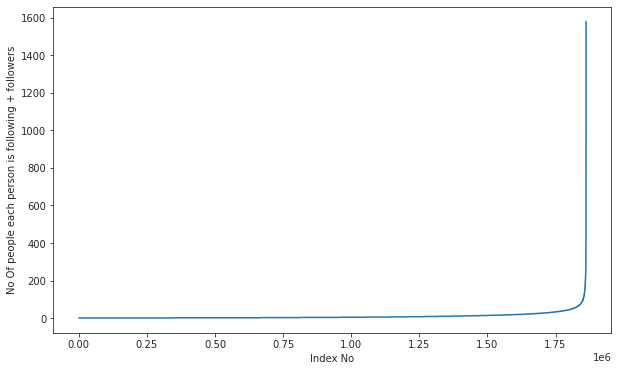

In [36]:
# Analyzing the total followers + followees 
in_out_degree_sort = sorted(in_out_degree)
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort)
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following + followers')
plt.show()

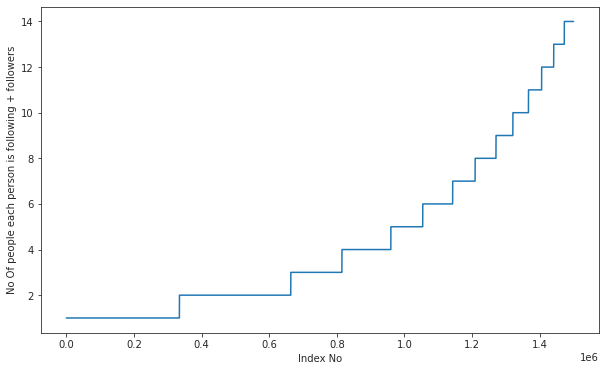

In [37]:
# Analyzing total indegree+outdegree with limited intervals
in_out_degree_sort = sorted(in_out_degree)
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort[0:1500000]) # total connections limited to 1.5M
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following + followers')
plt.show()

In [38]:
### 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(in_out_degree_sort,90+i))

90 percentile value is 24.0
91 percentile value is 26.0
92 percentile value is 28.0
93 percentile value is 31.0
94 percentile value is 33.0
95 percentile value is 37.0
96 percentile value is 41.0
97 percentile value is 48.0
98 percentile value is 58.0
99 percentile value is 79.0
100 percentile value is 1579.0


In [39]:
### 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(in_out_degree_sort,99+(i/100)))

99.1 percentile value is 83.0
99.2 percentile value is 87.0
99.3 percentile value is 93.0
99.4 percentile value is 99.0
99.5 percentile value is 108.0
99.6 percentile value is 120.0
99.7 percentile value is 138.0
99.8 percentile value is 168.0
99.9 percentile value is 221.0
100.0 percentile value is 1579.0


##### observation : 99.9% of total followers have indegree and outdegree has less than 221 connections

In [40]:
print('Min of no of followers + following is',in_out_degree.min())
print(np.sum(in_out_degree==in_out_degree.min()),' persons having minimum no of followers + following')

Min of no of followers + following is 1
334291  persons having minimum no of followers + following


In [41]:
print('Max of no of followers + following is',in_out_degree.max())
print(np.sum(in_out_degree==in_out_degree.max()),' persons having maximum no of followers + following')

Max of no of followers + following is 1579
1  persons having maximum no of followers + following


In [42]:
print('No of persons having followers + following less than 10 are',np.sum(in_out_degree<10))

No of persons having followers + following less than 10 are 1320326


In [43]:
print('No of weakly connected components',len(list(nx.weakly_connected_components(g))))
count=0
for i in list(nx.weakly_connected_components(g)):
    if len(i)==2:
        count+=1
print('weakly connected components wit 2 nodes',count)

No of weakly connected components 45558
weakly connected components wit 2 nodes 32195


# 2. Posing a problem as classification problem

### 2.1 Generating some edges which are not present in graph for supervised learning

 Generated Bad links from graph which are not in graph and whose shortest path is greater than 2

In [44]:
%%time
###generating bad edges from given graph
import random
if not os.path.isfile('/kaggle/working/missing_edges_final.p'): # if the final file is not present in the path
    #getting all set of edges
    r = csv.reader(open('/kaggle/working/train_woheader.csv','r')) 
    edges = dict()
    for edge in r: # going through each line as an edge
        edges[(edge[0], edge[1])] = 1 # if edge is present in r then 1
        
        
    missing_edges = set([]) # creating the variable to store the bad-links
    while (len(missing_edges)<9437519): # iterating upto 9.4M edges
        a=random.randint(1, 1862220) # creating random user u1
        b=random.randint(1, 1862220) # creating random user u2
        tmp = edges.get((a,b),-1) # marked -1 for all edges which are missing.
        if tmp == -1 and a!=b: # if edge is missing and a and b are not same.
            try:
                if nx.shortest_path_length(g,source=a,target=b) > 2: # checking for length of edges >2

                    missing_edges.add((a,b))# adding points who less likely to be friends
                else:
                    continue  
            except:  
                    missing_edges.add((a,b))              
        else:
            continue
    pickle.dump(missing_edges,open('/kaggle/working/missing_edges_final.p','wb')) # storing as pickle file
else:
    missing_edges = pickle.load(open('/kaggle/working/missing_edges_final.p','rb'))

CPU times: user 4h 35min 53s, sys: 16 s, total: 4h 36min 9s
Wall time: 4h 36min 20s


In [8]:
import pickle
missing_edges = pickle.load(open('/kaggle/working/missing_edges_final.p','rb'))
len(missing_edges)

9437519

# 2.2 Training and Test data split

Removed edges from Graph and used as test data and after removing used that graph for creating features for Train and test data

In [9]:
import os
os.chdir('/kaggle/working/')

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
# if file is pesent at current working directory
if (os.path.isfile('/kaggle/working/train_pos_after_eda.csv')) and (os.path.isfile('/kaggle/working/test_pos_after_eda.csv')):
    #reading total data df with test and train data information
    df_pos = pd.read_csv('../input/fb-recommendation/train.csv')
    df_neg = pd.DataFrame(list(missing_edges), columns=['source_node', 'destination_node'])
    
    print("Number of nodes in the graph with edges", df_pos.shape[0])
    print("Number of nodes in the graph without edges", df_neg.shape[0])
     
    #Spiltting data into 80-20 ratio
    # creating positive links and negative links seperatly because we need positive training data only for creating graph 
    #and for feature generation
    X_train_pos, X_test_pos, y_train_pos, y_test_pos  = train_test_split(df_pos,np.ones(len(df_pos)),test_size=0.2, random_state=9)
    X_train_neg, X_test_neg, y_train_neg, y_test_neg  = train_test_split(df_neg,np.zeros(len(df_neg)),test_size=0.2, random_state=9)
    
    print('='*50)
    print("Number of nodes in the train data graph with edges", X_train_pos.shape[0],"=",y_train_pos.shape[0])
    print("Number of nodes in the train data graph without edges", X_train_neg.shape[0],"=", y_train_neg.shape[0])
    print('='*50)
    print("Number of nodes in the test data graph with edges", X_test_pos.shape[0],"=",y_test_pos.shape[0])
    print("Number of nodes in the test data graph without edges", X_test_neg.shape[0],"=",y_test_neg.shape[0])

    #removing header and saving
    X_train_pos.to_csv('/kaggle/working/train_pos_after_eda.csv',header=False, index=False)
    X_test_pos.to_csv('/kaggle/working/test_pos_after_eda.csv',header=False, index=False)
    X_train_neg.to_csv('/kaggle/working/train_neg_after_eda.csv',header=False, index=False)
    X_test_neg.to_csv('/kaggle/working/test_neg_after_eda.csv',header=False, index=False)
else:
    #Graph from Traing data only 
    print('deleting ........')
    del missing_edges

Number of nodes in the graph with edges 9437519
Number of nodes in the graph without edges 9437519
Number of nodes in the train data graph with edges 7550015 = 7550015
Number of nodes in the train data graph without edges 7550015 = 7550015
Number of nodes in the test data graph with edges 1887504 = 1887504
Number of nodes in the test data graph without edges 1887504 = 1887504


In [11]:
import networkx as nx
#Reading edges for both train and test data
if (os.path.isfile('/kaggle/working/train_pos_after_eda.csv')) and (os.path.isfile('/kaggle/working/test_pos_after_eda.csv')):        
    train_graph=nx.read_edgelist('/kaggle/working/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    test_graph=nx.read_edgelist('/kaggle/working/test_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(train_graph))
    print(nx.info(test_graph))

    # finding the unique nodes in the both train and test graphs(set creates unique no of records)
    train_nodes_pos = set(train_graph.nodes())
    test_nodes_pos = set(test_graph.nodes())

    trY_teY = len(train_nodes_pos.intersection(test_nodes_pos))# finding common users in train and test
    trY_teN = len(train_nodes_pos - test_nodes_pos) # users in train but not test
    teY_trN = len(test_nodes_pos - train_nodes_pos) # users in test but not train

    print('no of people common in train and test -- ',trY_teY)
    print('no of people present in train but not present in test -- ',trY_teN)

    print('no of people present in test but not present in train -- ',teY_trN)
    print(' % of people not there in Train but exist in Test in total Test data are {} %'.format(teY_trN/len(test_nodes_pos)*100))

Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399
Name: 
Type: DiGraph
Number of nodes: 1144623
Number of edges: 1887504
Average in degree:   1.6490
Average out degree:   1.6490
no of people common in train and test --  1063125
no of people present in train but not present in test --  717597
no of people present in test but not present in train --  81498
 % of people not there in Train but exist in Test in total Test data are 7.1200735962845405 %


###### We might have cold start problem here

##### What is cold start problem?

![what is cold start problem](1_Gjxa4DyKs-1D6gysazF7Pw.png)

If the nodes are present in train data but not in test data or vice-versa.<br>
From diagram, we see that node 2 is not present in training data but it is present in test data.<br>
Similarly, node 4, 6 are present is test data but not present is training data.<br>
##### Till now we have source node , destination node and the target/labelled attribute (0 : edge is not present in our dataset and 1 : edge is present in our dataset).<br>
But the problem is that, we cannot used this dataset for building machine learning model. We need features so that it will help model for better prediction.

In [12]:
#final train and test data sets
import os
import pandas as pd
import numpy as np
if (not os.path.isfile('/kaggle/working/train_after_eda.csv')) and \
(not os.path.isfile('/kaggle/working/test_after_eda.csv')) and \
(not os.path.isfile('/kaggle/working/train_y.csv')) and \
(not os.path.isfile('/kaggle/working/test_y.csv')) and \
(os.path.isfile('/kaggle/working/train_pos_after_eda.csv')) and \
(os.path.isfile('/kaggle/working/test_pos_after_eda.csv')) and \
(os.path.isfile('/kaggle/working/train_neg_after_eda.csv')) and \
(os.path.isfile('/kaggle/working/test_neg_after_eda.csv')):
    
    X_train_pos = pd.read_csv('/kaggle/working/train_pos_after_eda.csv', names=['source_node', 'destination_node'])
    X_test_pos = pd.read_csv('/kaggle/working/test_pos_after_eda.csv', names=['source_node', 'destination_node'])
    X_train_neg = pd.read_csv('/kaggle/working/train_neg_after_eda.csv', names=['source_node', 'destination_node'])
    X_test_neg = pd.read_csv('/kaggle/working/test_neg_after_eda.csv', names=['source_node', 'destination_node'])

    print('='*50)
    print("Number of nodes in the train data graph with edges", X_train_pos.shape[0])
    print("Number of nodes in the train data graph without edges", X_train_neg.shape[0])
    print('='*50)
    print("Number of nodes in the test data graph with edges", X_test_pos.shape[0])
    print("Number of nodes in the test data graph without edges", X_test_neg.shape[0])

    X_train = X_train_pos.append(X_train_neg,ignore_index=True)
    y_train = np.concatenate((y_train_pos,y_train_neg))
    X_test = X_test_pos.append(X_test_neg,ignore_index=True)
    y_test = np.concatenate((y_test_pos,y_test_neg)) 
    
    X_train.to_csv('/kaggle/working/train_after_eda.csv',header=False,index=False)
    X_test.to_csv('/kaggle/working/test_after_eda.csv',header=False,index=False)
    pd.DataFrame(y_train.astype(int)).to_csv('/kaggle/working/train_y.csv',header=False,index=False)
    pd.DataFrame(y_test.astype(int)).to_csv('test_y.csv',header=False,index=False)

Number of nodes in the train data graph with edges 7550015
Number of nodes in the train data graph without edges 7550015
Number of nodes in the test data graph with edges 1887504
Number of nodes in the test data graph without edges 1887504


# Featurization

In [13]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm

# 1. Reading Data

In [14]:
#Reading the training data which has edges
train_graph=nx.read_edgelist('train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
print(nx.info(train_graph))

Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399


# 2. Similarity measures

### 2.1 Jaccard Distance:

##### Jaccard Dist. for followee

The nodes who are following to X or we can say that the successor of X.<br>
In set “A” consider all the incoming edges of X i.e. followees of X. A={A,D}<br>
In set “B” consider all the incoming edges of E. B={B}<br>
![](Jaccard.png)

##### Jaccard Dist. for followers
In set “A” consider all the outgoing edges of X. A={C,D}<br>
The nodes who are followed by X .i.e predecessor of X.<br>
In set “B” consider all the outgoing edges of E. B={B}<br>
###### Note:
Jaccard distance is generally used to normalized the features.<br>
If the Jaccard distance is more then possibility of connecting two people is more.<br>
$$
Jaccard-distance = \frac{|X\cap Y|}{|X \cup Y|} 
$$

In [15]:
#for followees--outgoing edges
def jaccard_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0: # base condition
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (len(set(train_graph.successors(a)).union(set(train_graph.successors(b)))))
    except:
        return 0
    return sim

In [16]:
#one test case
print(jaccard_for_followees(273084,1505602))

0.0


In [17]:
#node 1635354 not in graph 
print(jaccard_for_followees(273084,1505602))

0.0


In [18]:
#for followers  - incoming edges
def jaccard_for_followers(a,b):
    try:
        if len(set(train_graph.predecessors(a))) == 0  | len(set(g.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                 (len(set(train_graph.predecessors(a)).union(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

In [19]:

print(jaccard_for_followers(273084,470294))

0


In [20]:
#node 1635354 not in graph 
print(jaccard_for_followees(669354,1635354))

0



# 2.2 Cosine distance

Cosine similarity is a measure of similarity between two non-zero vectors of an inner product space that measures the cosine of the angle between them. The cosine of 0° is 1, and it is less than 1 for any angle in the interval 0, π] radians.

![](Cosine.png)

$$
CosineDistance = \frac{|X\cap Y|}{|X|\cdot|Y|} 
$$

In [21]:
#for followees
def cosine_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (math.sqrt(len(set(train_graph.successors(a)))*len((set(train_graph.successors(b))))))
        return sim
    except:
        return 0

In [22]:
print(cosine_for_followees(273084,1505602))

0.0


In [23]:

print(cosine_for_followees(273084,1635354))

0


In [24]:

def cosine_for_followers(a,b):
    try:
        
        if len(set(train_graph.predecessors(a))) == 0  | len(set(train_graph.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                     (math.sqrt(len(set(train_graph.predecessors(a))))*(len(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

In [25]:
print(cosine_for_followers(2,470294))

0.02886751345948129


In [26]:
# random edge
print(cosine_for_followers(669354,1635354))

0


# 3. Ranking Measures
https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.link_analysis.pagerank_alg.pagerank.html

PageRank computes a ranking of the nodes in the graph G based on the structure of the incoming links.



Mathematical PageRanks for a simple network, expressed as percentages. (Google uses a logarithmic scale.) Page C has a higher PageRank than Page E, even though there are fewer links to C; the one link to C comes from an important page and hence is of high value. If web surfers who start on a random page have an 85% likelihood of choosing a random link from the page they are currently visiting, and a 15% likelihood of jumping to a page chosen at random from the entire web, they will reach Page E 8.1% of the time. (The 15% likelihood of jumping to an arbitrary page corresponds to a damping factor of 85%.) Without damping, all web surfers would eventually end up on Pages A, B, or C, and all other pages would have PageRank zero. In the presence of damping, Page A effectively links to all pages in the web, even though it has no outgoing links of its own.

## 3.1 Page Ranking
https://en.wikipedia.org/wiki/PageRank

It is a way of measuring the importance of website pages.<br>
PageRank works by counting the number and quality of links to a page to determine a rough estimate of how important the page is.<br>
If a lot of pages are having a destination as “B”, then “B” must be important.<br>
If my page “B” is given as link in many important pages like C,E,D etc, then “B” page value increases.<br>

![](Pagerank.png)

In [27]:
if not os.path.isfile('page_rank.p'):
    pr = nx.pagerank(train_graph, alpha=0.85)
    pickle.dump(pr,open('page_rank.p','wb'))
else:
    pr = pickle.load(open('page_rank.p','rb'))

In [28]:
print('min',pr[min(pr, key=pr.get)])
print('max',pr[max(pr, key=pr.get)])
print('mean',float(sum(pr.values())) / len(pr))

min 1.6556497245737814e-07
max 2.7098251341935827e-05
mean 5.615699699389075e-07


In [29]:
#for imputing to nodes which are not there in Train data
mean_pr = float(sum(pr.values())) / len(pr)
print(mean_pr)

5.615699699389075e-07


# 4. Other Graph Features
## 4.1 Shortest path:
Getting Shortest path between twoo nodes, if nodes have direct path i.e directly connected then we are removing that edge and calculating path.

In [30]:
#if has direct edge then deleting that edge and calculating shortest path
def compute_shortest_path_length(a,b):
    p=-1 # -1 if there is no edge
    try:
        if train_graph.has_edge(a,b): # If edge exists
            train_graph.remove_edge(a,b) # remove the edge
            p= nx.shortest_path_length(train_graph,source=a,target=b)
            train_graph.add_edge(a,b)
        else:
            p= nx.shortest_path_length(train_graph,source=a,target=b) # This length measure how far the two vertices are
        return p
    except:
        return -1

In [31]:
#testing
compute_shortest_path_length(77697, 826021)

10

In [32]:
#testing
compute_shortest_path_length(669354,1635354)

-1

# 4.2 Checking for same community

##### Strongly Connected Component<br>
A graph is said to be strongly connected if every vertex is reachable from every other vertex.<br>
The strongly connected components of an arbitrary directed graph form a partition into subgraphs that are themselves strongly connected.<br>

![](SCC.png)

##### Weakly connected component
A weakly connected component is one in which all components are connected by some path, ignoring direction.<br>

![](wcc.png)

In [33]:
#getting weekly connected edges from graph 
wcc=list(nx.weakly_connected_components(train_graph))
def belongs_to_same_wcc(a,b):
    index = []
    if train_graph.has_edge(b,a):
        return 1
    if train_graph.has_edge(a,b):
            for i in wcc:
                if a in i:
                    index= i
                    break
            if (b in index):
                train_graph.remove_edge(a,b)
                if compute_shortest_path_length(a,b)==-1:
                    train_graph.add_edge(a,b)
                    return 0
                else:
                    train_graph.add_edge(a,b)
                    return 1
            else:
                return 0
    else:
            for i in wcc:
                if a in i:
                    index= i
                    break
            if(b in index):
                return 1
            else:
                return 0

In [34]:

belongs_to_same_wcc(861, 1659750)

0

In [35]:

belongs_to_same_wcc(669354,1635354)

0

# 4.3 Adamic/Adar Index:
Adamic/Adar measures is defined as inverted sum of degrees of common neighbours for given two vertices.$$A(x,y)=\sum_{u \in N(x) \cap N(y)}\frac{1}{log(|N(u)|)}$$

![](adar.png)

Here, let’s say, U1 and U2 are two vertex belonging to intersection of N(x) and N(y) and both are connected to both x and y.<br>
U1 has very large neighborhood, so it’s probably a celebrity. So there is a very small chance that x and y are going to be related.<br>
While U2 has small neighborhood, so it’s a common man like us. As it has small group, it can belong to a college group or work group, so x and y can be related in this case.<br>
As size of the N(u) increases, log(N(u)) increases and 1/log(N(u)) decreases. So contribution os nodes like U1 who have large no neighbors, their Adar Index is small and vice versa.<br>

In [36]:
#adar index
def calc_adar_in(a,b):
    sum=0
    try:
        n=list(set(train_graph.successors(a)).intersection(set(train_graph.successors(b))))# calculating intersection of indegree
        if len(n)!=0:
            for i in n:
                sum=sum+(1/np.log10(len(list(train_graph.predecessors(i)))))
            return sum
        else:
            return 0
    except:
        return 0

In [37]:

calc_adar_in(1,189226)

0

In [38]:
calc_adar_in(669354,1635354)

0

# 4.4 Is persion was following back:

In [39]:
def follows_back(a,b):
    if train_graph.has_edge(b,a):
        return 1
    else:
        return 0

In [40]:
follows_back(1,189226)

1

In [41]:
follows_back(669354,1635354)

0

# 4.5 Katz Centrality:
https://en.wikipedia.org/wiki/Katz_centrality

https://www.geeksforgeeks.org/katz-centrality-centrality-measure/ Katz centrality computes the centrality for a node based on the centrality of its neighbors. It is a generalization of the eigenvector centrality. The Katz centrality for node i is

$$x_i = \alpha \sum_{j} A_{ij} x_j + \beta,$$
where A is the adjacency matrix of the graph G with eigenvalues$$\lambda$$.

The parameter$$\beta$$controls the initial centrality and

$$\alpha &lt; \frac{1}{\lambda_{max}}.$$

Katz centrality computes the centrality for a node based on the centrality of it’s neighbors. It’s a generalization of eigenvector centrality.<br>
It is used to measure the relative degree of influence of neighboring nodeswithin a graph or social network.<br>

![](katz.png)

In [42]:
if not os.path.isfile('katz.p'):
    katz = nx.katz.katz_centrality(train_graph,alpha=0.005,beta=1)
    pickle.dump(katz,open('katz.p','wb'))
else:
    katz = pickle.load(open('katz.p','rb'))

In [43]:
print('min',katz[min(katz, key=katz.get)])
print('max',katz[max(katz, key=katz.get)])
print('mean',float(sum(katz.values())) / len(katz))

min 0.0007313532484065916
max 0.003394554981699122
mean 0.0007483800935562018


In [44]:
mean_katz = float(sum(katz.values())) / len(katz)
print(mean_katz)

0.0007483800935562018


# 4.6 Hits Score
The HITS algorithm computes two numbers for a node. Authorities estimates the node value based on the incoming links. Hubs estimates the node value based on outgoing links.

https://en.wikipedia.org/wiki/HITS_algorithm

![](hits.png)

HITS stands for Hyperlink-Induced Topic Search(often referred as hubs and authorities)is a link analysis algorithm that rates web pages.<br>
The HITS algorithm computes two numbers for a node. Authorities estimates the node value based on the incoming links. Hubs estimates the node value based on outgoing links.<br>
hubs → More no of outlinks, ex- yahoo.com<br>
Authorities → More no of inlinks, ex- cnn.com, bbc.com, mit.edu<br>
So, HITS gives every web page wi two scores <hubs, authorities>.<br>
Step 1: This is an iterative algorithm. At the very initial stage, for every page, we have auth(p) = 1 and hub(p) = 1.<br>
Step 2: Authority update rule : For each p, we update auth(p)<br>
Step 3: Hub update rule: For each p, we update hub(p)<br>
where Pfrom is all pages to which p links to.<br>
Step 4: If we keep running these update rules, they will run till infinity. So once we update the authority or hub score of any page, we normalize it so that the score does not become infinitely large.<br>

In [45]:
if not os.path.isfile('hits.p'):
    hits = nx.hits(train_graph, max_iter=100, tol=1e-08, nstart=None, normalized=True)
    pickle.dump(hits,open('hits.p','wb'))
else:
    hits = pickle.load(open('hits.p','rb'))

In [46]:
print('min',hits[0][min(hits[0], key=hits[0].get)])
print('max',hits[0][max(hits[0], key=hits[0].get)])
print('mean',float(sum(hits[0].values())) / len(hits[0]))

min 0.0
max 0.004868653378780953
mean 5.615699699344123e-07


# 5. Featurization

In [47]:
import random
if os.path.isfile('train_after_eda.csv'):
    filename = "train_after_eda.csv"
    # you uncomment this line, if you dont know the lentgh of the file name
    # here we have hardcoded the number of lines as 15100030
    # n_train = sum(1 for line in open(filename)) #number of records in file (excludes header)
    n_train =  15100028
    s = 100000 #desired sample size
    skip_train = sorted(random.sample(range(1,n_train+1),n_train-s)) # random sampling
    #https://stackoverflow.com/a/22259008/4084039

In [48]:
if os.path.isfile('train_after_eda.csv'):
    filename = "test_after_eda.csv"
    # you uncomment this line, if you dont know the lentgh of the file name
    # here we have hardcoded the number of lines as 3775008
    # n_test = sum(1 for line in open(filename)) #number of records in file (excludes header)
    n_test = 3775006
    s = 50000 #desired sample size
    skip_test = sorted(random.sample(range(1,n_test+1),n_test-s)) # random sampling
    #https://stackoverflow.com/a/22259008/4084039

In [49]:
print("Number of rows in the train data file:", n_train)
print("Number of rows we are going to elimiate in train data are",len(skip_train))
print("Number of rows in the test data file:", n_test)
print("Number of rows we are going to elimiate in test data are",len(skip_test))

Number of rows in the train data file: 15100028
Number of rows we are going to elimiate in train data are 15000028
Number of rows in the test data file: 3775006
Number of rows we are going to elimiate in test data are 3725006


In [50]:
# final data frame
df_final_train = pd.read_csv('train_after_eda.csv', skiprows=skip_train, names=['source_node', 'destination_node'])
df_final_train['indicator_link'] = pd.read_csv('train_y.csv', skiprows=skip_train, names=['indicator_link'])
print("Our train matrix size ",df_final_train.shape)
df_final_train.head(2)

Our train matrix size  (100002, 3)


,source_node,destination_node,indicator_link
0,273084,1505602,1
1,521886,292052,1


In [51]:

df_final_test = pd.read_csv('test_after_eda.csv', skiprows=skip_test, names=['source_node', 'destination_node'])
df_final_test['indicator_link'] = pd.read_csv('test_y.csv', skiprows=skip_test, names=['indicator_link'])
print("Our test matrix size ",df_final_test.shape)
df_final_test.head(2)

Our test matrix size  (50002, 3)


,source_node,destination_node,indicator_link
0,848424,784690,1
1,328683,807380,1


# 5.2 Adding a set of features
we will create these each of these features for both train and test data points

1.jaccard_followers<br>
2.jaccard_followees<br>
3.cosine_followers<br>
4.cosine_followees<br>
5.num_followers_s<br>
6.num_followees_s<br>
7.num_followers_d<br>
8.num_followees_d<br>
9.inter_followers<br>
10.inter_followees<br>

In [52]:
if not os.path.isfile('storage_sample_stage1.h5'):
    #mapping jaccard followers to train and test data
    df_final_train['jaccard_followers'] = df_final_train.apply(lambda row:
                                            jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)
    df_final_test['jaccard_followers'] = df_final_test.apply(lambda row:
                                            jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)

    #mapping jaccard followees to train and test data
    df_final_train['jaccard_followees'] = df_final_train.apply(lambda row:
                                            jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)
    df_final_test['jaccard_followees'] = df_final_test.apply(lambda row:
                                            jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)
    

    #mapping jaccard followers to train and test data
    df_final_train['cosine_followers'] = df_final_train.apply(lambda row:
                                            cosine_for_followers(row['source_node'],row['destination_node']),axis=1)
    df_final_test['cosine_followers'] = df_final_test.apply(lambda row:
                                            cosine_for_followers(row['source_node'],row['destination_node']),axis=1)

    #mapping jaccard followees to train and test data
    df_final_train['cosine_followees'] = df_final_train.apply(lambda row:
                                            cosine_for_followees(row['source_node'],row['destination_node']),axis=1)
    df_final_test['cosine_followees'] = df_final_test.apply(lambda row:
                                            cosine_for_followees(row['source_node'],row['destination_node']),axis=1)

In [53]:
def compute_features_stage1(df_final):
    #calculating no of followers followees for source and destination
    #calculating intersection of followers and followees for source and destination
    num_followers_s=[]
    num_followees_s=[]
    num_followers_d=[]
    num_followees_d=[]
    inter_followers=[]
    inter_followees=[]
    for i,row in df_final.iterrows():
        try:
            s1=set(train_graph.predecessors(row['source_node'])) # creating set of followers
            s2=set(train_graph.successors(row['source_node']))# creting set of followees
        except:
            s1 = set()
            s2 = set()
        try:
            d1=set(train_graph.predecessors(row['destination_node']))
            d2=set(train_graph.successors(row['destination_node']))
        except:
            d1 = set()
            d2 = set()
        num_followers_s.append(len(s1))
        num_followees_s.append(len(s2))

        num_followers_d.append(len(d1))
        num_followees_d.append(len(d2))

        inter_followers.append(len(s1.intersection(d1)))
        inter_followees.append(len(s2.intersection(d2)))
    
    return num_followers_s, num_followers_d, num_followees_s, num_followees_d, inter_followers, inter_followees

In [54]:
# adding features created into dataframe
if not os.path.isfile('storage_sample_stage1.h5'):
    df_final_train['num_followers_s'], df_final_train['num_followers_d'], \
    df_final_train['num_followees_s'], df_final_train['num_followees_d'], \
    df_final_train['inter_followers'], df_final_train['inter_followees']= compute_features_stage1(df_final_train)
    
    df_final_test['num_followers_s'], df_final_test['num_followers_d'], \
    df_final_test['num_followees_s'], df_final_test['num_followees_d'], \
    df_final_test['inter_followers'], df_final_test['inter_followees']= compute_features_stage1(df_final_test)
    
    hdf = HDFStore('storage_sample_stage1.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('storage_sample_stage1.h5', 'train_df',mode='r')
    df_final_test = read_hdf('storage_sample_stage1.h5', 'test_df',mode='r')

# 5.3 Adding new set of features¶
we will create these each of these features for both train and test data points

1.adar index</br>
2.is following back</br>
3.belongs to same weakly connect components</br>
4.shortest path between source and destination</br>

In [56]:
if not os.path.isfile('storage_sample_stage2.h5'):
    #mapping adar index on train
    df_final_train['adar_index'] = df_final_train.apply(lambda row: calc_adar_in(row['source_node'],row['destination_node']),axis=1)
    #mapping adar index on test
    df_final_test['adar_index'] = df_final_test.apply(lambda row: calc_adar_in(row['source_node'],row['destination_node']),axis=1)

    #--------------------------------------------------------------------------------------------------------
    #mapping followback or not on train
    df_final_train['follows_back'] = df_final_train.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)

    #mapping followback or not on test
    df_final_test['follows_back'] = df_final_test.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)

    #--------------------------------------------------------------------------------------------------------
    #mapping same component of wcc or not on train
    df_final_train['same_comp'] = df_final_train.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)

    ##mapping same component of wcc or not on train
    df_final_test['same_comp'] = df_final_test.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)
    
    print("--------------------------------------------------------------------------------------------------------")
    #mapping shortest path on train 
    df_final_train['shortest_path'] = df_final_train.apply(lambda row: compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)
    #mapping shortest path on test
    df_final_test['shortest_path'] = df_final_test.apply(lambda row: compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)

    hdf = HDFStore('storage_sample_stage2.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('storage_sample_stage2.h5', 'train_df',mode='r')
    df_final_test = read_hdf('storage_sample_stage2.h5', 'test_df',mode='r')

--------------------------------------------------------------------------------------------------------


# 5.4 Adding new set of features
we will create these each of these features for both train and test data points

1.Weight Features</br>
weight of incoming edges
weight of outgoing edges
weight of incoming edges + weight of outgoing edges
weight of incoming edges * weight of outgoing edges
2*weight of incoming edges + weight of outgoing edges
weight of incoming edges + 2*weight of outgoing edges
2.Page Ranking of source</br>
3.Page Ranking of dest</br>
4.katz of source</br>
5.katz of dest</br>
6.hubs of source</br>
7.hubs of dest</br>
8.authorities_s of source</br>
9.authorities_s of dest</br>
10.Weight Features</br>
In order to determine the similarity of nodes, an edge weight value was calculated between nodes. Edge weight decreases as the neighbor count goes up. Intuitively, consider one million people following a celebrity on a social network then chances are most of them never met each other or the celebrity. On the other hand, if a user has 30 contacts in his/her social network, the chances are higher that many of them know each other. credit - Graph-based Features for Supervised Link Prediction William Cukierski, Benjamin Hamner, Bo Yang

$$
W = \frac{1}{\sqrt{1+|X|}}
$$
it is directed graph so calculated Weighted in and Weighted out differently

In [57]:
#weight for source and destination of each link
Weight_in = {}
Weight_out = {}
for i in  tqdm(train_graph.nodes()):
    s1=set(train_graph.predecessors(i)) # formula for followers
    w_in = 1.0/(np.sqrt(1+len(s1)))
    Weight_in[i]=w_in
    
    s2=set(train_graph.successors(i)) # formula for followees
    w_out = 1.0/(np.sqrt(1+len(s2)))
    Weight_out[i]=w_out
    
#for imputing with mean
mean_weight_in = np.mean(list(Weight_in.values()))
mean_weight_out = np.mean(list(Weight_out.values()))

100%|██████████| 1780722/1780722 [00:22<00:00, 80530.97it/s] 


##### adding up additionally engineered features

weight of incoming edges<br>
weight of outgoing edges<br>
weight of incoming edges + weight of outgoing edges<br>
weight of incoming edges * weight of outgoing edges<br>
2*weight of incoming edges + weight of outgoing edges<br>
weight of incoming edges + 2*weight of outgoing edges<br>

In [58]:
if not os.path.isfile('storage_sample_stage3.h5'):
    #mapping to pandas train
    df_final_train['weight_in'] = df_final_train.destination_node.apply(lambda x: Weight_in.get(x,mean_weight_in))
    df_final_train['weight_out'] = df_final_train.source_node.apply(lambda x: Weight_out.get(x,mean_weight_out))

    #mapping to pandas test
    df_final_test['weight_in'] = df_final_test.destination_node.apply(lambda x: Weight_in.get(x,mean_weight_in))
    df_final_test['weight_out'] = df_final_test.source_node.apply(lambda x: Weight_out.get(x,mean_weight_out))


    #some features engineerings on the in and out weights for train data
    df_final_train['weight_f1'] = df_final_train.weight_in + df_final_train.weight_out
    df_final_train['weight_f2'] = df_final_train.weight_in * df_final_train.weight_out
    df_final_train['weight_f3'] = (2*df_final_train.weight_in + 1*df_final_train.weight_out)
    df_final_train['weight_f4'] = (1*df_final_train.weight_in + 2*df_final_train.weight_out)

    #some features engineerings on the in and out weights for test data
    df_final_test['weight_f1'] = df_final_test.weight_in + df_final_test.weight_out
    df_final_test['weight_f2'] = df_final_test.weight_in * df_final_test.weight_out
    df_final_test['weight_f3'] = (2*df_final_test.weight_in + 1*df_final_test.weight_out)
    df_final_test['weight_f4'] = (1*df_final_test.weight_in + 2*df_final_test.weight_out)

##### adding pagerank, katz,HITS score features

In [59]:
if not os.path.isfile('storage_sample_stage3.h5'):
    
    #page rank for source and destination in Train and Test
    #if anything not there in train graph then adding mean page rank 
    df_final_train['page_rank_s'] = df_final_train.source_node.apply(lambda x:pr.get(x,mean_pr))
    df_final_train['page_rank_d'] = df_final_train.destination_node.apply(lambda x:pr.get(x,mean_pr))

    df_final_test['page_rank_s'] = df_final_test.source_node.apply(lambda x:pr.get(x,mean_pr))
    df_final_test['page_rank_d'] = df_final_test.destination_node.apply(lambda x:pr.get(x,mean_pr))
    #================================================================================

    #Katz centrality score for source and destination in Train and test
    #if anything not there in train graph then adding mean katz score
    df_final_train['katz_s'] = df_final_train.source_node.apply(lambda x: katz.get(x,mean_katz))
    df_final_train['katz_d'] = df_final_train.destination_node.apply(lambda x: katz.get(x,mean_katz))

    df_final_test['katz_s'] = df_final_test.source_node.apply(lambda x: katz.get(x,mean_katz))
    df_final_test['katz_d'] = df_final_test.destination_node.apply(lambda x: katz.get(x,mean_katz))
    #================================================================================

    #Hits algorithm score for source and destination in Train and test
    #if anything not there in train graph then adding 0
    df_final_train['hubs_s'] = df_final_train.source_node.apply(lambda x: hits[0].get(x,0))
    df_final_train['hubs_d'] = df_final_train.destination_node.apply(lambda x: hits[0].get(x,0))

    df_final_test['hubs_s'] = df_final_test.source_node.apply(lambda x: hits[0].get(x,0))
    df_final_test['hubs_d'] = df_final_test.destination_node.apply(lambda x: hits[0].get(x,0))
    #================================================================================

    #Hits algorithm score for source and destination in Train and Test
    #if anything not there in train graph then adding 0
    df_final_train['authorities_s'] = df_final_train.source_node.apply(lambda x: hits[1].get(x,0))
    df_final_train['authorities_d'] = df_final_train.destination_node.apply(lambda x: hits[1].get(x,0))

    df_final_test['authorities_s'] = df_final_test.source_node.apply(lambda x: hits[1].get(x,0))
    df_final_test['authorities_d'] = df_final_test.destination_node.apply(lambda x: hits[1].get(x,0))
    #================================================================================

    hdf = HDFStore('storage_sample_stage3.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('storage_sample_stage3.h5', 'train_df',mode='r')
    df_final_test = read_hdf('storage_sample_stage3.h5', 'test_df',mode='r')

In [60]:
df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,...,weight_f3,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d
0,273084,1505602,1,0,0.0,0.0,0.0,11,6,15,...,1.005929,0.877964,2.045290e-06,3.459963e-07,0.000773,0.000756,1.943132e-13,1.941103e-13,9.226339e-16,2.231877e-15
1,521886,292052,1,0,0.0,0.0,0.0,5,22,4,...,0.864242,1.102942,2.759878e-07,1.981996e-06,0.000751,0.000817,3.279633e-16,1.167313e-15,7.433445e-15,1.779990e-15
2,196908,494916,1,0,0.0,0.0,0.0,4,4,6,...,1.272392,1.203143,1.040678e-06,8.020109e-07,0.000746,0.000746,7.946439e-20,9.051786e-20,4.416660e-22,8.375945e-18
3,1319826,1008121,1,0,0.0,0.0,0.0,4,32,6,...,0.726120,0.930007,8.577000e-07,3.931571e-06,0.000746,0.000852,5.757498e-17,1.150147e-16,1.789830e-17,1.498073e-15
4,1163731,575776,1,0,0.0,0.0,0.0,3,10,2,...,1.180373,1.456212,5.602839e-07,1.813865e-06,0.000743,0.000769,1.201165e-18,5.055814e-16,3.624077e-18,1.669325e-16


## Adding new feature Preferential Attachement
One well-known concept in social networks is that users with many friends tend to create more connections in the future. This is due to the fact that in some social networks, like in finance, the rich get richer. We estimate how ”rich” our two vertices are by calculating the multiplication between the number of friends (|Γ(x)|) or followers each vertex has.

Preferential Attachement for followers

In [61]:
#for train dataset, the summation of followers for source node and destination node
nfs=np.array(df_final_train['num_followers_s'])
nfd=np.array(df_final_train['num_followers_d'])
preferential_followers=[]
for i in range(len(nfs)):
    preferential_followers.append(nfd[i]*nfs[i])
df_final_train['prefer_Attach_followers']= preferential_followers
df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,...,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d,prefer_Attach_followers
0,273084,1505602,1,0,0.0,0.0,0.0,11,6,15,...,0.877964,2.045290e-06,3.459963e-07,0.000773,0.000756,1.943132e-13,1.941103e-13,9.226339e-16,2.231877e-15,66
1,521886,292052,1,0,0.0,0.0,0.0,5,22,4,...,1.102942,2.759878e-07,1.981996e-06,0.000751,0.000817,3.279633e-16,1.167313e-15,7.433445e-15,1.779990e-15,110
2,196908,494916,1,0,0.0,0.0,0.0,4,4,6,...,1.203143,1.040678e-06,8.020109e-07,0.000746,0.000746,7.946439e-20,9.051786e-20,4.416660e-22,8.375945e-18,16
3,1319826,1008121,1,0,0.0,0.0,0.0,4,32,6,...,0.930007,8.577000e-07,3.931571e-06,0.000746,0.000852,5.757498e-17,1.150147e-16,1.789830e-17,1.498073e-15,128
4,1163731,575776,1,0,0.0,0.0,0.0,3,10,2,...,1.456212,5.602839e-07,1.813865e-06,0.000743,0.000769,1.201165e-18,5.055814e-16,3.624077e-18,1.669325e-16,30


In [62]:
#for test dataset, the summation of followers for source node and destination node
nfs=np.array(df_final_test['num_followers_s'])
nfd=np.array(df_final_test['num_followers_d'])
preferential_followers=[]
for i in range(len(nfs)):
    preferential_followers.append(nfd[i]*nfs[i])
df_final_test['prefer_Attach_followers']= preferential_followers
df_final_test.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,...,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d,prefer_Attach_followers
0,848424,784690,1,0,0.000000,0.029161,0.000000,6,14,6,...,1.014128,6.557971e-07,1.559547e-06,0.000754,0.000786,3.243237e-16,1.745627e-16,2.969838e-15,9.269213e-14,84
1,328683,807380,1,0,0.076923,0.102062,0.142857,6,4,7,...,1.154320,6.428994e-07,5.898623e-07,0.000754,0.000746,1.209512e-17,1.697661e-17,4.299861e-17,4.264282e-18,24
2,2736,1096560,1,0,0.500000,0.116927,0.670820,14,16,20,...,0.678971,5.750073e-07,6.530229e-07,0.000787,0.000795,4.920694e-167,6.311428e-167,2.740379e-166,3.444994e-166,224
3,713880,167361,1,0,0.000000,0.000000,0.000000,18,22,19,...,0.655728,9.345818e-07,1.154745e-06,0.000802,0.000818,6.081399e-14,3.027039e-14,2.033050e-14,2.845418e-13,396
4,1802128,1634556,1,0,0.037736,0.010532,0.078689,46,14,38,...,0.578455,2.738619e-06,1.490613e-06,0.000921,0.000786,4.873617e-13,2.907127e-13,2.684132e-11,8.472320e-15,644


In [63]:
#for train dataset, the summation of followees for source node and destination node
nfs=np.array(df_final_train['num_followees_s'])
nfd=np.array(df_final_train['num_followees_d'])
preferential_followees=[]
for i in range(len(nfs)):
    preferential_followees.append(nfd[i]*nfs[i])
df_final_train['prefer_Attach_followees']= preferential_followees
df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,...,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d,prefer_Attach_followers,prefer_Attach_followees
0,273084,1505602,1,0,0.0,0.0,0.0,11,6,15,...,2.045290e-06,3.459963e-07,0.000773,0.000756,1.943132e-13,1.941103e-13,9.226339e-16,2.231877e-15,66,120
1,521886,292052,1,0,0.0,0.0,0.0,5,22,4,...,2.759878e-07,1.981996e-06,0.000751,0.000817,3.279633e-16,1.167313e-15,7.433445e-15,1.779990e-15,110,108
2,196908,494916,1,0,0.0,0.0,0.0,4,4,6,...,1.040678e-06,8.020109e-07,0.000746,0.000746,7.946439e-20,9.051786e-20,4.416660e-22,8.375945e-18,16,24
3,1319826,1008121,1,0,0.0,0.0,0.0,4,32,6,...,8.577000e-07,3.931571e-06,0.000746,0.000852,5.757498e-17,1.150147e-16,1.789830e-17,1.498073e-15,128,108
4,1163731,575776,1,0,0.0,0.0,0.0,3,10,2,...,5.602839e-07,1.813865e-06,0.000743,0.000769,1.201165e-18,5.055814e-16,3.624077e-18,1.669325e-16,30,26


In [64]:
#for test dataset
nfs=np.array(df_final_test['num_followees_s'])
nfd=np.array(df_final_test['num_followees_d'])
preferential_followees=[]
for i in range(len(nfs)):
    preferential_followees.append(nfd[i]*nfs[i])
df_final_test['prefer_Attach_followees']= preferential_followees
df_final_test.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,...,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d,prefer_Attach_followers,prefer_Attach_followees
0,848424,784690,1,0,0.000000,0.029161,0.000000,6,14,6,...,6.557971e-07,1.559547e-06,0.000754,0.000786,3.243237e-16,1.745627e-16,2.969838e-15,9.269213e-14,84,54
1,328683,807380,1,0,0.076923,0.102062,0.142857,6,4,7,...,6.428994e-07,5.898623e-07,0.000754,0.000746,1.209512e-17,1.697661e-17,4.299861e-17,4.264282e-18,24,49
2,2736,1096560,1,0,0.500000,0.116927,0.670820,14,16,20,...,5.750073e-07,6.530229e-07,0.000787,0.000795,4.920694e-167,6.311428e-167,2.740379e-166,3.444994e-166,224,500
3,713880,167361,1,0,0.000000,0.000000,0.000000,18,22,19,...,9.345818e-07,1.154745e-06,0.000802,0.000818,6.081399e-14,3.027039e-14,2.033050e-14,2.845418e-13,396,608
4,1802128,1634556,1,0,0.037736,0.010532,0.078689,46,14,38,...,2.738619e-06,1.490613e-06,0.000921,0.000786,4.873617e-13,2.907127e-13,2.684132e-11,8.472320e-15,644,646


## 5.5 Adding new set of features¶
we will create these each of these features for both train and test data points

SVD features for both source and destination

So you are given a graph G with directed edges Ui → Uj.<br>
There is a concept called adjacency matrix which represents all of the information which we have in our graph(which has around 1.78 million users) in the form of a matrix.<br>
Adjacency matrix changes graph to graph. Let’s stick to the graph we have.<br>
Adjacency matrix(A) of G, where A is of size 1.78M x 1.78M.<br>
This matrix is going to be a nxn matrix, whose ijth cell is going to be 1 if there is a directed edge from Ui to Uj else 0.<br>
In our case, our adjacency matric is binary matrix.<br>
There are other variation of matrix for undirected graphs called weighted graphs, for now let’s stick to directed graphs.<br>
We will get very large and sparse matrix as most of the values will be zero.<br>
We will decompose the adjacency matrix using SVD.<br>
A = U Σ VT<br>
Where U = size of 1.78M x 6<br>
Σ = size of 6 x 6<br>
VT(transpose) = size of 6 x 1.78M<br>
In A, U’s ith row represents the same size vector as VT’s ith column. Both are the same size vector representation of ith vertex of the graph. We got this using left singular matrix U and right singular matrix VT.<br>
So, for the pair of vertices where we need to predict if there is an edge or not, we have 24 features (for Ui-u-6,vt-6, Uj-u-6,vt-6).<br>
Matrix Factorization helps to incorporate implicit feedback i.e information that is not directly given but can be derived from analyzing user behavior.<br>

In [65]:
def svd(x, S):
    try:
        z = sadj_dict[x]
        return S[z]
    except:
        return [0,0,0,0,0,0]

In [66]:
#for svd features to get feature vector creating a dict node val and inedx in svd vector
sadj_col = sorted(train_graph.nodes())
sadj_dict = { val:idx for idx,val in enumerate(sadj_col)}

In [67]:
Adj = nx.adjacency_matrix(train_graph,nodelist=sorted(train_graph.nodes())).asfptype()

In [68]:
U, s, V = svds(Adj, k = 6) # no of components=6
print('Adjacency matrix Shape',Adj.shape)
print('U Shape',U.shape)
print('V Shape',V.shape)
print('s Shape',s.shape)

Adjacency matrix Shape (1780722, 1780722)
U Shape (1780722, 6)
V Shape (6, 1780722)
s Shape (6,)


##### adding the featurized SVD vectors with 6 components into the final data (oth source and destination)

In [69]:
if not os.path.isfile('storage_sample_stage4.h5'):
    #===================================================================================================
    
    df_final_train[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
    df_final_train.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
    df_final_train[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
    df_final_train.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    #===================================================================================================
    
    df_final_train[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
    df_final_train.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

    df_final_train[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
    df_final_train.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
    #===================================================================================================
    
    df_final_test[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
    df_final_test.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
    df_final_test[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
    df_final_test.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)

    #===================================================================================================
    
    df_final_test[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
    df_final_test.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

    df_final_test[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
    df_final_test.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
    #===================================================================================================

#     hdf = HDFStore('data/fea_sample/storage_sample_stage4.h5')
#     hdf.put('train_df',df_final_train, format='table', data_columns=True)
#     hdf.put('test_df',df_final_test, format='table', data_columns=True)
#     hdf.close()

In [70]:
df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,...,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6
0,273084,1505602,1,0,0.0,0.0,0.0,11,6,15,...,1.983701e-06,1.545085e-13,8.108440e-13,1.719637e-14,-1.355345e-12,4.675307e-13,1.128586e-06,6.616621e-14,9.771080e-13,4.159879e-14
1,521886,292052,1,0,0.0,0.0,0.0,5,22,4,...,8.668020e-09,9.297026e-13,5.670659e-10,1.385519e-13,-6.376796e-12,5.397430e-10,3.398834e-09,1.416160e-11,3.248015e-10,3.317727e-14
2,196908,494916,1,0,0.0,0.0,0.0,4,4,6,...,2.537288e-15,3.319222e-18,1.555270e-17,7.940028e-21,-6.195112e-16,3.593675e-14,1.990164e-14,1.488901e-15,2.565393e-15,1.561195e-16
3,1319826,1008121,1,0,0.0,0.0,0.0,4,32,6,...,1.701237e-13,9.733956e-15,1.153094e-13,3.336069e-16,-5.992132e-13,3.907023e-10,4.679066e-11,8.657469e-13,8.601852e-13,2.792268e-14
4,1163731,575776,1,0,0.0,0.0,0.0,3,10,2,...,7.499360e-13,1.813106e-15,2.588925e-14,6.754883e-17,-4.660712e-13,8.934704e-13,1.016153e-11,9.086194e-14,6.296065e-12,3.111464e-15


In [71]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followers_d',
       'num_followees_s', 'num_followees_d', 'inter_followers',
       'inter_followees', 'adar_index', 'follows_back', 'same_comp',
       'shortest_path', 'weight_in', 'weight_out', 'weight_f1', 'weight_f2',
       'weight_f3', 'weight_f4', 'page_rank_s', 'page_rank_d', 'katz_s',
       'katz_d', 'hubs_s', 'hubs_d', 'authorities_s', 'authorities_d',
       'prefer_Attach_followers', 'prefer_Attach_followees', 'svd_u_s_1',
       'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6',
       'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5',
       'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4',
       'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3',
       'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6'],
      dtype='object')

##### Adding feature svd_dot<br>
svd_dot is Dot product between sourse node svd and destination node svd features

In [72]:

#for train datasets
s1,s2,s3,s4,s5,s6=df_final_train['svd_u_s_1'],df_final_train['svd_u_s_2'],df_final_train['svd_u_s_3'],df_final_train['svd_u_s_4'],df_final_train['svd_u_s_5'],df_final_train['svd_u_s_6']
s7,s8,s9,s10,s11,s12=df_final_train['svd_v_s_1'],df_final_train['svd_v_s_2'],df_final_train['svd_v_s_3'],df_final_train['svd_v_s_4'],df_final_train['svd_v_s_5'],df_final_train['svd_v_s_6']

d1,d2,d3,d4,d5,d6=df_final_train['svd_u_d_1'],df_final_train['svd_u_d_2'],df_final_train['svd_u_d_3'],df_final_train['svd_u_d_4'],df_final_train['svd_u_d_5'],df_final_train['svd_u_d_6']
d7,d8,d9,d10,d11,d12=df_final_train['svd_v_d_1'],df_final_train['svd_v_d_2'],df_final_train['svd_v_d_3'],df_final_train['svd_v_d_4'],df_final_train['svd_v_d_5'],df_final_train['svd_v_d_6']

In [73]:
# Adding SVD values into list and performing dot product
svd_dot=[]
for i in range(len(np.array(s1))):
    a=[]
    b=[]
    a.append(np.array(s1[i]))
    a.append(np.array(s2[i]))
    a.append(np.array(s3[i]))
    a.append(np.array(s4[i]))
    a.append(np.array(s5[i]))
    a.append(np.array(s6[i]))
    a.append(np.array(s7[i]))
    a.append(np.array(s8[i]))
    a.append(np.array(s9[i]))
    a.append(np.array(s10[i]))
    a.append(np.array(s11[i]))
    a.append(np.array(s12[i]))
    b.append(np.array(d1[i]))
    b.append(np.array(d2[i]))
    b.append(np.array(d3[i]))
    b.append(np.array(d4[i]))
    b.append(np.array(d5[i]))
    b.append(np.array(d6[i]))
    b.append(np.array(d7[i]))
    b.append(np.array(d8[i]))
    b.append(np.array(d9[i]))
    b.append(np.array(d10[i]))
    b.append(np.array(d11[i]))
    b.append(np.array(d12[i]))
    svd_dot.append(np.dot(a,b))
df_final_train['svd_dot']=svd_dot

In [74]:
df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,...,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,svd_dot
0,273084,1505602,1,0,0.0,0.0,0.0,11,6,15,...,1.545085e-13,8.108440e-13,1.719637e-14,-1.355345e-12,4.675307e-13,1.128586e-06,6.616621e-14,9.771080e-13,4.159879e-14,1.338828e-11
1,521886,292052,1,0,0.0,0.0,0.0,5,22,4,...,9.297026e-13,5.670659e-10,1.385519e-13,-6.376796e-12,5.397430e-10,3.398834e-09,1.416160e-11,3.248015e-10,3.317727e-14,3.001368e-17
2,196908,494916,1,0,0.0,0.0,0.0,4,4,6,...,3.319222e-18,1.555270e-17,7.940028e-21,-6.195112e-16,3.593675e-14,1.990164e-14,1.488901e-15,2.565393e-15,1.561195e-16,3.868016e-27
3,1319826,1008121,1,0,0.0,0.0,0.0,4,32,6,...,9.733956e-15,1.153094e-13,3.336069e-16,-5.992132e-13,3.907023e-10,4.679066e-11,8.657469e-13,8.601852e-13,2.792268e-14,5.182546e-22
4,1163731,575776,1,0,0.0,0.0,0.0,3,10,2,...,1.813106e-15,2.588925e-14,6.754883e-17,-4.660712e-13,8.934704e-13,1.016153e-11,9.086194e-14,6.296065e-12,3.111464e-15,1.741633e-23


In [75]:
#for test dataset
s1,s2,s3,s4,s5,s6=df_final_test['svd_u_s_1'],df_final_test['svd_u_s_2'],df_final_test['svd_u_s_3'],df_final_test['svd_u_s_4'],df_final_test['svd_u_s_5'],df_final_test['svd_u_s_6']
s7,s8,s9,s10,s11,s12=df_final_test['svd_v_s_1'],df_final_test['svd_v_s_2'],df_final_test['svd_v_s_3'],df_final_test['svd_v_s_4'],df_final_test['svd_v_s_5'],df_final_test['svd_v_s_6']

d1,d2,d3,d4,d5,d6=df_final_test['svd_u_d_1'],df_final_test['svd_u_d_2'],df_final_test['svd_u_d_3'],df_final_test['svd_u_d_4'],df_final_test['svd_u_d_5'],df_final_test['svd_u_d_6']
d7,d8,d9,d10,d11,d12=df_final_test['svd_v_d_1'],df_final_test['svd_v_d_2'],df_final_test['svd_v_d_3'],df_final_test['svd_v_d_4'],df_final_test['svd_v_d_5'],df_final_test['svd_v_d_6']

In [76]:
# Adding SVD values into list and performing dot product
svd_dot=[]
for i in range(len(np.array(s1))):
    a=[]
    b=[]
    a.append(np.array(s1[i]))
    a.append(np.array(s2[i]))
    a.append(np.array(s3[i]))
    a.append(np.array(s4[i]))
    a.append(np.array(s5[i]))
    a.append(np.array(s6[i]))
    a.append(np.array(s7[i]))
    a.append(np.array(s8[i]))
    a.append(np.array(s9[i]))
    a.append(np.array(s10[i]))
    a.append(np.array(s11[i]))
    a.append(np.array(s12[i]))
    b.append(np.array(d1[i]))
    b.append(np.array(d2[i]))
    b.append(np.array(d3[i]))
    b.append(np.array(d4[i]))
    b.append(np.array(d5[i]))
    b.append(np.array(d6[i]))
    b.append(np.array(d7[i]))
    b.append(np.array(d8[i]))
    b.append(np.array(d9[i]))
    b.append(np.array(d10[i]))
    b.append(np.array(d11[i]))
    b.append(np.array(d12[i]))
    svd_dot.append(np.dot(a,b))
df_final_test['svd_dot']=svd_dot

In [77]:
df_final_test.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,...,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,svd_dot
0,848424,784690,1,0,0.000000,0.029161,0.000000,6,14,6,...,2.701538e-12,4.341622e-13,5.535503e-14,-9.994077e-10,5.791913e-10,3.512353e-07,2.486660e-09,2.771146e-09,1.727694e-12,2.083228e-17
1,328683,807380,1,0,0.076923,0.102062,0.142857,6,4,7,...,6.276803e-15,2.742959e-10,8.013837e-16,-1.509009e-15,8.926532e-14,1.887916e-13,8.709743e-15,4.060924e-14,7.948135e-17,1.199265e-23
2,2736,1096560,1,0,0.500000,0.116927,0.670820,14,16,20,...,1.308047e-19,-4.851805e-20,-1.568528e-20,1.321932e-19,3.101785e-19,-2.788505e-19,1.460783e-19,-6.283713e-20,-2.036846e-20,9.164992e-36
3,713880,167361,1,0,0.000000,0.000000,0.000000,18,22,19,...,4.605436e-11,8.600769e-10,3.789403e-13,-1.988122e-11,1.909592e-09,1.973835e-09,7.699180e-11,8.795278e-10,5.303595e-12,1.649218e-16
4,1802128,1634556,1,0,0.037736,0.010532,0.078689,46,14,38,...,2.988299e-08,1.145892e-11,5.002974e-10,-2.224998e-12,3.048847e-12,5.197997e-07,5.928659e-12,1.166042e-12,1.579154e-13,6.059810e-11


In [78]:
hdf = HDFStore('storage_sample_stage4.h5')
hdf.put('train_df',df_final_train, format='table', data_columns=True)
hdf.put('test_df',df_final_test, format='table', data_columns=True)
hdf.close()

# Model Building

In [79]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [80]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followers_d',
       'num_followees_s', 'num_followees_d', 'inter_followers',
       'inter_followees', 'adar_index', 'follows_back', 'same_comp',
       'shortest_path', 'weight_in', 'weight_out', 'weight_f1', 'weight_f2',
       'weight_f3', 'weight_f4', 'page_rank_s', 'page_rank_d', 'katz_s',
       'katz_d', 'hubs_s', 'hubs_d', 'authorities_s', 'authorities_d',
       'prefer_Attach_followers', 'prefer_Attach_followees', 'svd_u_s_1',
       'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6',
       'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5',
       'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4',
       'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3',
       'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6', 'svd_dot'],
      dtype='object')

In [81]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [82]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

Estimators =  10 Train Score 0.9087710948089438 test Score 0.8729102695325827
Estimators =  50 Train Score 0.920839393309786 test Score 0.8911928128925127
Estimators =  100 Train Score 0.9224266275207962 test Score 0.909384977314737
Estimators =  250 Train Score 0.922119873291097 test Score 0.9142211244610039
Estimators =  450 Train Score 0.9225379281580731 test Score 0.9145669703633889


Text(0.5, 1.0, 'Estimators vs score at depth of 5')

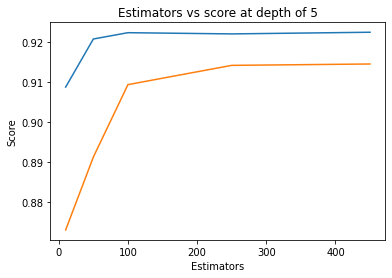

In [83]:
estimators = [10,50,100,250,450]
train_scores = []
test_scores = []
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

depth =  3 Train Score 0.8899613496291653 test Score 0.8645408979417724
depth =  9 Train Score 0.9586576716830998 test Score 0.9209978773039659
depth =  11 Train Score 0.9622989717901398 test Score 0.9182026921699563
depth =  15 Train Score 0.9654077557004904 test Score 0.922931739540736
depth =  20 Train Score 0.9656302138631881 test Score 0.9196330892872171
depth =  35 Train Score 0.9657159611359937 test Score 0.9200714961623383
depth =  50 Train Score 0.9657159611359937 test Score 0.9200714961623383
depth =  70 Train Score 0.9657159611359937 test Score 0.9200714961623383
depth =  130 Train Score 0.9657159611359937 test Score 0.9200714961623383


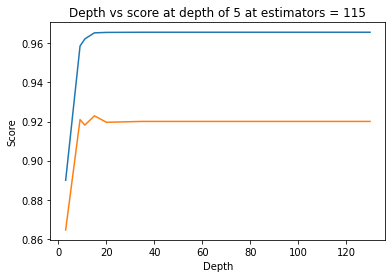

In [84]:
depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 115')
plt.show()

In [ ]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}
# base models with random numbers with range between 105,125
clf = RandomForestClassifier(random_state=25,n_jobs=-1)
rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25)
rf_random.fit(df_final_train,y_train)

In [86]:
print(rf_random.best_estimator_)

RandomForestClassifier(max_depth=14, min_samples_leaf=28, min_samples_split=111,
                       n_estimators=121, n_jobs=-1, random_state=25)


In [87]:
# fitting model with best parameters
clf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=28, min_samples_split=111,
            min_weight_fraction_leaf=0.0, n_estimators=121, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)

In [88]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [89]:
# calculating F1 score for train and test
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9658614615182133
Test f1 score 0.9235160775753505


##### Function to plot confusion matrix for both train and test

In [92]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("orange")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


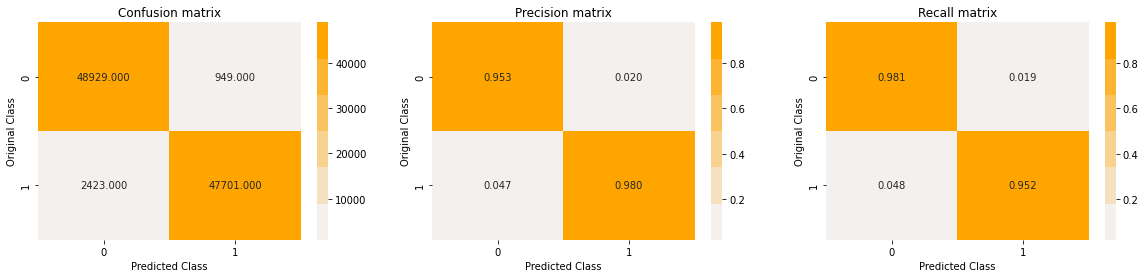

Test confusion_matrix


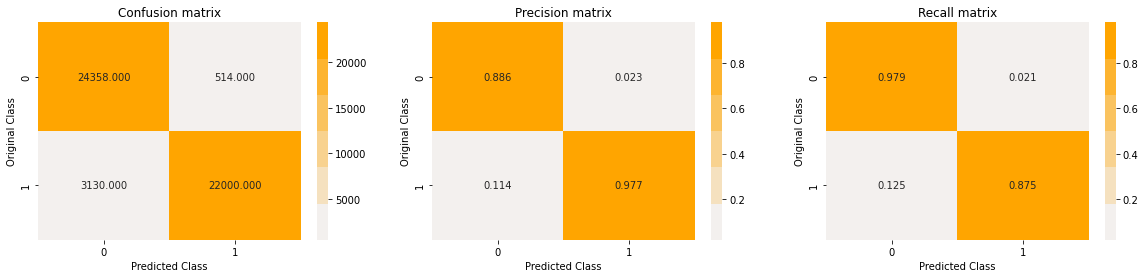

In [93]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

##### Observation : both precision and recall for true positives , and true negatives are over than 0.95 for train data. Also, for test data the same metrics are observed to be above 0.85.

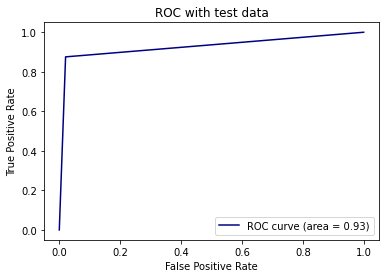

In [94]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC with test data')
plt.legend()
plt.show()

##### Extracting the feature importances from model

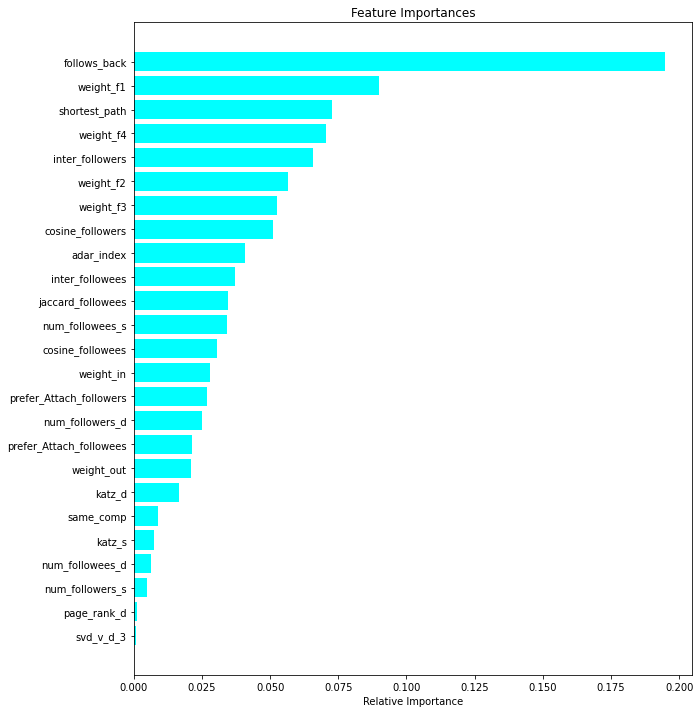

In [96]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='cyan', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

##### <br> follows_back <br> weight_f1 <br> shortest path <br> 
The above are the top-3 features derived from RF classifier

# Applying XGBOOST

In [ ]:
import xgboost as xgb
clf = xgb.XGBClassifier()
param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15)
              }
model = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=3,scoring='f1',random_state=23)

model.fit(df_final_train,y_train)

In [98]:
print(model.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=114, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


In [99]:
# Training the classifier with best parameters
clf=xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.3, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=114,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [ ]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [101]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9658614615182133
Test f1 score 0.9235160775753505


Train confusion_matrix


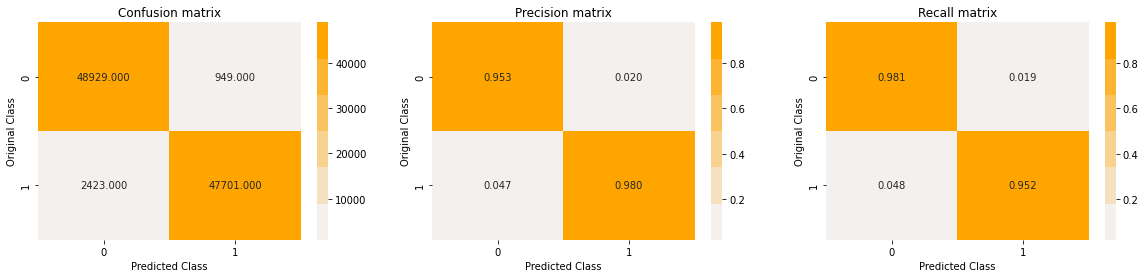

Test confusion_matrix


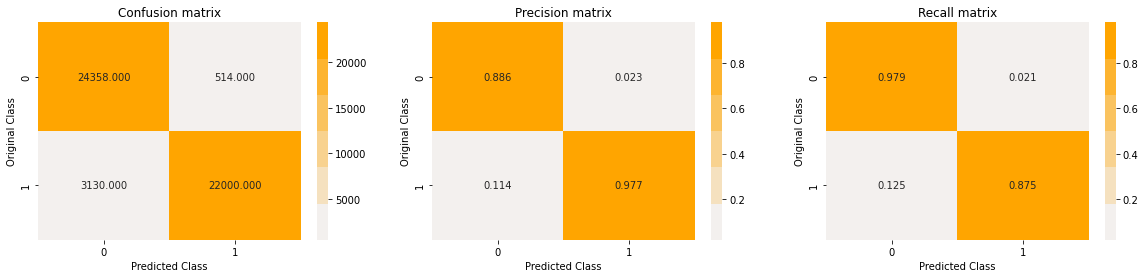

In [102]:
# Confusion matrics for train and test
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

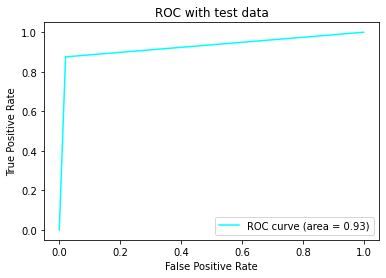

In [104]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='cyan',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC with test data')
plt.legend()
plt.show()

##### Feature importances from XGBoost

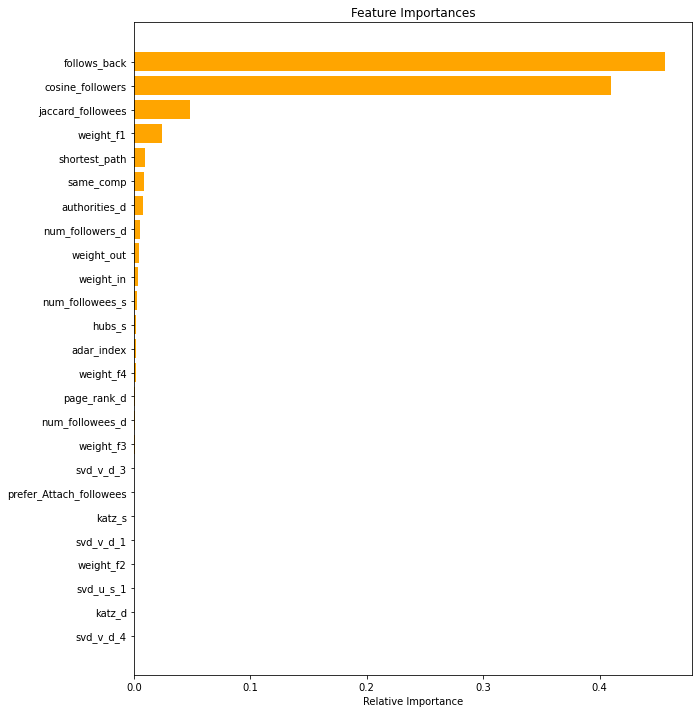

In [106]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='orange', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

##### Observation : Followsback, cosine_followers and Jaccard followers are the top-3 features which explains maximum variance

## Procedure and Observation

In [1]:
from prettytable import PrettyTable 
x = PrettyTable()
x.field_names = ["Model", "Train f1-Score","Test f1-Score"]
x.add_row(['Random Forest','0.964','0.923'])
x.add_row(['XGBOOST','0.965','0.920'])
print(x)

+---------------+----------------+---------------+
|     Model     | Train f1-Score | Test f1-Score |
+---------------+----------------+---------------+
| Random Forest |     0.964      |     0.923     |
|    XGBOOST    |     0.965      |     0.920     |
+---------------+----------------+---------------+
